In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#this is for importing the sklearn libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch

from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import morphology

In [2]:
#loads the image in the color format
original_img=cv2.imread('image/3063.jpg' , 1)
img = np.copy (original_img)

In [3]:
def plot_images (img , title):
    plt.figure(figsize = (10 , 10))
    plt.imshow(img , cmap = 'gray')
    plt.xticks([])
    plt.yticks([]) 
    plt.title (title)

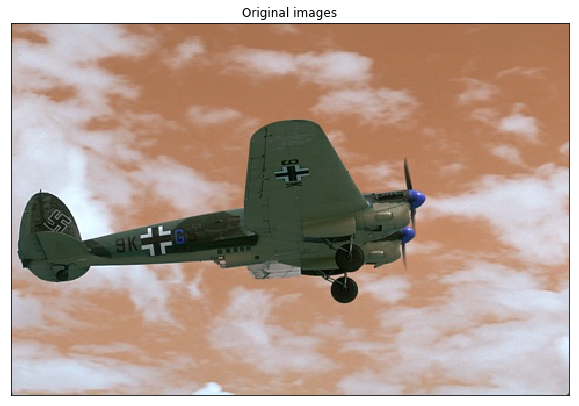

In [4]:
#this is for plotting the images
plot_images(original_img , "Original images")

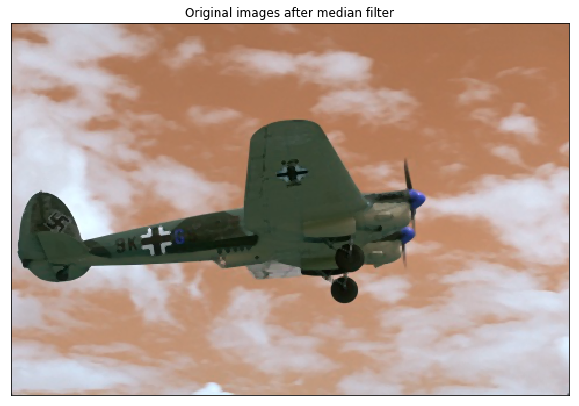

In [5]:
#this is the median blur that is used to remove the noise from the image
#takes median of all the pixels under kernel area and central element is replaced with this median value. 
#This is highly effective against salt-and-pepper noise in the images.
original2 = cv2.medianBlur(original_img, 3)
plot_images(original2 , "Original images after median filter")

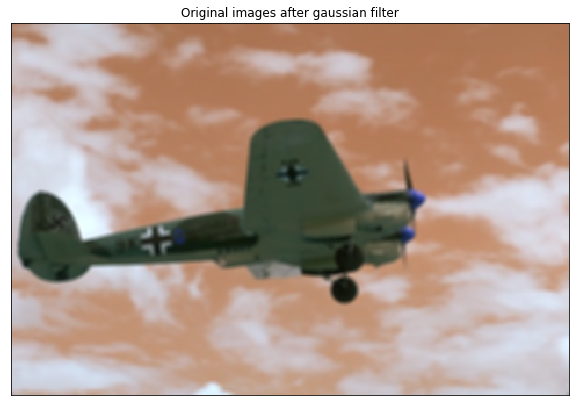

In [6]:
#this is used to smoothen the image

original3 = cv2.GaussianBlur(original2,(5 , 5),3)
plot_images(original3 , "Original images after gaussian filter")

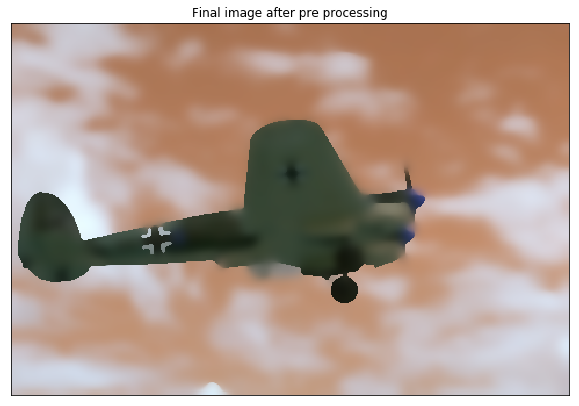

In [7]:
#this is for the median filtering
#cv2.bilateralFilter() is highly effective in noise removal while keeping edges sharp.
#But the operation is slower compared to other filters.#
#gaussian filter takes the a neighbourhood around the pixel and find its gaussian weighted average.
# This gaussian filter is a function of space alone, that is, nearby pixels are considered while filtering. 
#It doesn't consider whether pixels have almost same intensity. 
#It doesn't consider whether pixel is an edge pixel or not. So it blurs the edges also, which we don't want to do.

final = original2
for _ in range(5):
    final = cv2.bilateralFilter (final , 9 , 75 , 75)

plot_images(final , "Final image after pre processing")

In [8]:
#reshaping the image
image_shape = final.shape
img_flatten = final.reshape ((-1 , 3))

In [9]:
#using the kmeans without any pre transform
cluster = KMeans(n_clusters=2)
cluster.fit(img_flatten)
cluster_centers = cluster.cluster_centers_
cluster_labels = cluster.labels_

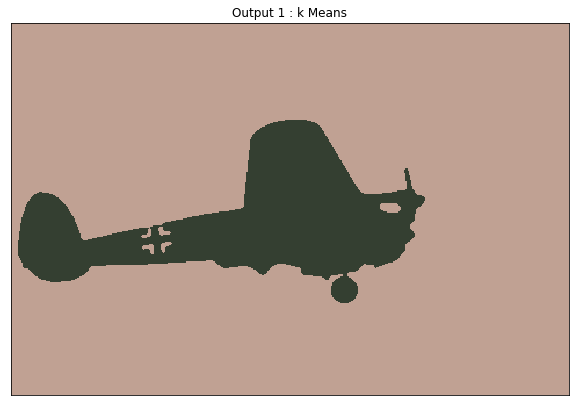

In [10]:
output_kmeans = cluster_centers[cluster_labels].reshape(image_shape)
plot_images(output_kmeans/255 , "Output 1 : k Means")

In [11]:
img_for_pca = final.reshape((3 , -1))
print (img_for_pca.shape)

#now this is to use the PCA to decrease the number of components
pca = PCA (n_components=100 , random_state=0)
pca.fit (img_for_pca)
img_transform_pca = pca.transform (img_for_pca)
img_reverse_pca = pca.inverse_transform (img_transform_pca)

(3, 154401)


Text(0,0.5,'cumulatitive explained variance')

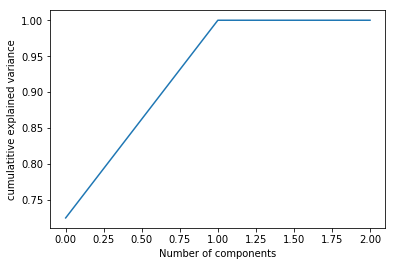

In [12]:
#plotting the explained variance shape
plt.plot (np.cumsum(pca.explained_variance_ratio_))
plt.xlabel ("Number of components")
plt.ylabel ("cumulatitive explained variance")

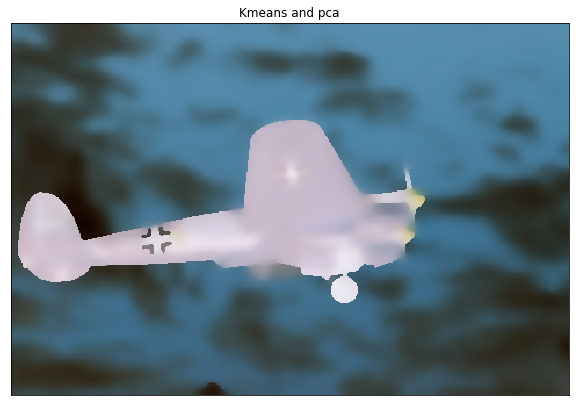

In [13]:
#plotting the image after the reconstruction from the pca

clusters = pca.explained_variance_ratio_.shape[0]

cluster = KMeans(n_clusters=clusters)
cluster.fit(img_reverse_pca)
cluster_centers = cluster.cluster_centers_
cluster_labels = cluster.labels_

final_kmeans_pca = cluster_centers[cluster_labels].reshape(image_shape)
plot_images( (final_kmeans_pca * 255).astype(np.uint8) , "Kmeans and pca")

Text(0.5,1,'histogram of gray values')

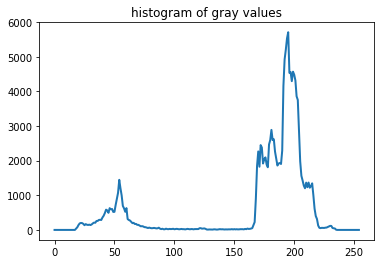

In [14]:
hist = np.histogram(final_kmeans_pca[: , : , 0], bins=np.arange(0, 256))
plt.plot(hist[1][:-1], hist[0], lw=2)
plt.title('histogram of gray values')

In [15]:
image = final_kmeans_pca[: , : , 0]

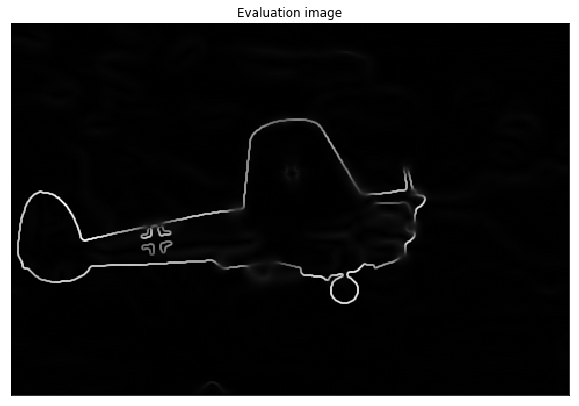

In [16]:
#Find the edge magnitude using the Sobel transform.
from skimage.filters import sobel
elevation_map = sobel(image)
plot_images(elevation_map, "Evaluation image" )

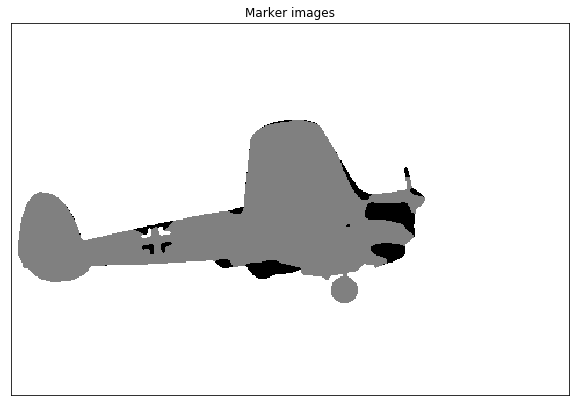

In [17]:
#this is to threshold the images
markers = np.zeros_like(elevation_map)
markers[image < 75] = 1
markers[image > 150] = 2
plot_images(markers , "Marker images")

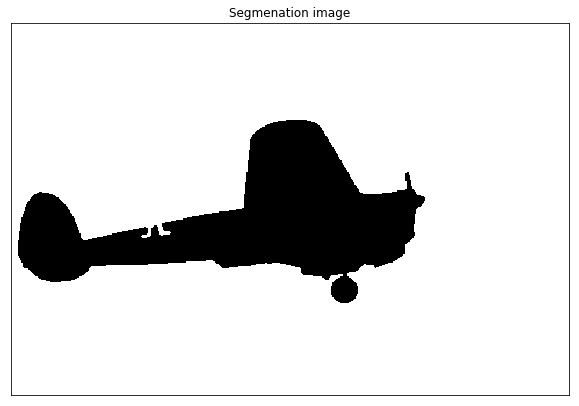

In [18]:
#The watershed transformation treats the image it operates upon like a topographic map,
#with the brightness of each point representing its height, and finds the lines that run along the tops of ridges.


#Starting from user-defined markers, the watershed algorithm treats pixels values as a local topography (elevation).
#The algorithm floods basins from the markers, until basins attributed to different markers meet on watershed lines.
# In many cases, markers are chosen as local minima of the image, from which basins are flooded.
segmentation = morphology.watershed(elevation_map, markers)
plot_images(segmentation , "Segmenation image")

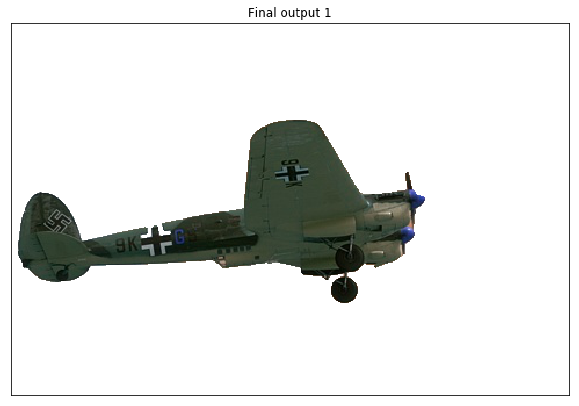

In [19]:
final_output = np.ones (image_shape) * 255
for x in range(image_shape[0]):
    for y in range(image_shape[1]):
        if (segmentation[x,y] == 1):
            final_output[x,y] = original_img[x,y]

plot_images(final_output/255, "Final output 1")

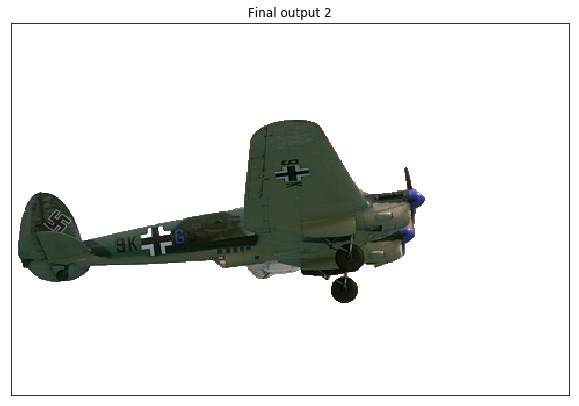

In [20]:
#this is dealing just with the threshold
#it finds out the threshold and then divide the image depending on that.
#the threshold is found out from the histogram

final_output2 = np.ones (image_shape) * 255
for x in range(image_shape[0]):
    for y in range(image_shape[1]):
        if (markers[x,y] != 2):
            final_output2[x,y] = original_img[x,y]

plot_images(final_output2/255, "Final output 2")